# Auto Exposure

This is a setup/test/demonstration notebook for the `AutoExposure` effect in Scopesim. This effect splits the requested total exposure time into NDIT subexposures of integration time DIT such that the maximum counts in a single subexposure does not exceed a certain fill fraction of the detector full well. The final readout is the sum over the NDIT subexposures, i.e. corresponds to the total requested exposure time.

The notebook uses the `irdb/METIS` configuration. The observed source is blank sky, except for the last example where a star of 0 mag is used (Vega).

In [1]:
from astropy import units as u
import scopesim as sim
import matplotlib.pyplot as plt

sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out.
sim.link_irdb("../../../../")

Python:
3.10.18 (main, Jun  5 2025, 13:08:10) [GCC 11.2.0]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.3.3
             astropy: 6.1.7
      beautifulsoup4: 4.13.4
            docutils: 0.19
               httpx: 0.28.1
                lxml: 5.4.0
          matplotlib: 3.10.5
      more-itertools: 10.7.0
               numpy: 1.26.4
           packaging: 25.0
               pooch: 1.8.2
              pyyaml: 6.0.2
               scipy: 1.15.3
            scopesim: 0.10.0
       scopesim_data: could not be loaded.
  scopesim_templates: 0.6.2
         skycalc-ipy: 0.5.3
             synphot: 1.6.0
                tqdm: 4.67.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2025-06-30
      METIS: 2025-06-30

Operating System info:
   System: Linux
  Release: 6.12.13-200.fc41.aarch64
  Version: #1 SMP PREEMPT_DYNAMIC Sat Feb  8 20:30:50 UTC 2025
  Machine: aarch64


If you haven't got the instrument packages yet, uncomment the following cell. 

In [2]:
# sim.download_packages(["METIS", "ELT", "Armazones"])

## Imaging LM-band

In [3]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["img_lm"])
metis = sim.OpticalTrain(cmd)

In [4]:
metis.observe()

astar.scopesim.optics.optical_train - Observing empty field


For `AutoExposure` to work the exposure time has to be given explicitely as a parameter to the `readout` method. If this is not done, the default values for `DIT` and `NDIT` will be used. The following is for an exposure time of 1 second. The resulting readout is divided by `NDIT` to produce the average over the `NDIT` subexposures. After application of the gain to convert from ADU to electrons this allows direct comparison to the detector full well. 

In [5]:
outhdul = metis.readout(exptime=1)[0]
gain = outhdul[1].header["ESO DET1 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET1 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.309 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.250 s, NDIT = 4
astar.scopesim.effects.electronic - Total exposure time: 1.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.250 s, NDIT = 4
astar.scopesim.effects.electronic - Total exposure time: 1.000 s

Result
Maximum value in readout: 61296.6 electron (per DIT)
Detector full well:        100000 electron
Fill fraction:               61.3 %


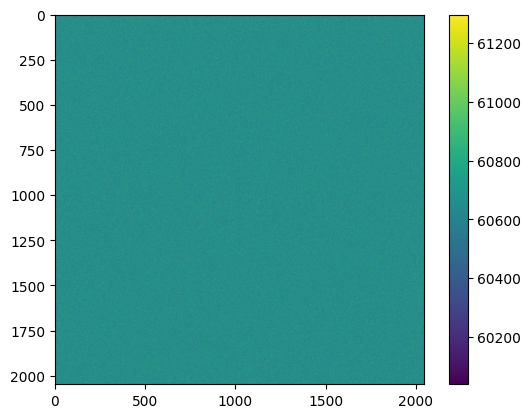

In [6]:
plt.clf()
plt.imshow(outimg*(1/u.electron))
plt.colorbar()
plt.show()

The same with a much larger exposure time of 1000 seconds:

In [7]:
outhdul = metis.readout(exptime = 1000)[0]
gain = outhdul[1].header["ESO DET1 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET1 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1000.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.309 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.309 s, NDIT = 3236
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.309 s, NDIT = 3236
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s

Result
Maximum value in readout: 75007.3 electron (per DIT)
Detector full well:        100000 electron
Fill fraction:               75.0 %


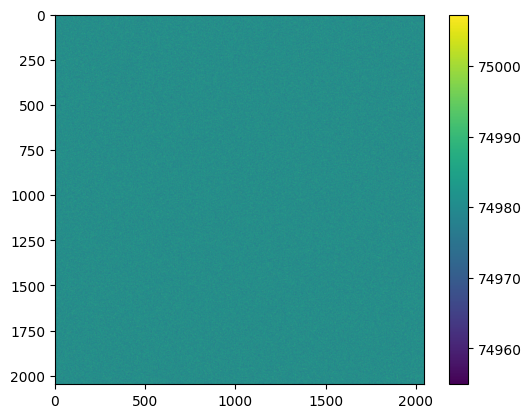

In [8]:
plt.clf()
plt.imshow(outimg*(1/u.electron))
plt.colorbar()
plt.show()

The desired fill fraction can be changed with the argument `fill_frac`. The default value of 75 per cent is a typical good value that keeps the detector counts within the linear regime.

In [9]:
outhdul = metis.readout(exptime = 1000, fill_frac=0.9)[0]
gain = outhdul[1].header["ESO DET1 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET1 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1000.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.309 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.309 s, NDIT = 3236
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.309 s, NDIT = 3236
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s

Result
Maximum value in readout: 75005.4 electron (per DIT)
Detector full well:        100000 electron
Fill fraction:               75.0 %


In [10]:
outimg.data.shape

(2048, 2048)

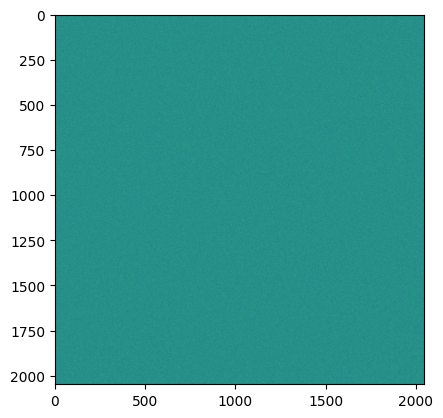

In [11]:
plt.clf()
plt.imshow(outimg*(1/u.electron))
plt.show()

## Imaging N-band

In [12]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["img_n"])
metis = sim.OpticalTrain(cmd)

In [13]:
metis.observe()

astar.scopesim.optics.optical_train - Observing empty field


 FOVs:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
outhdul = metis.readout(exptime=1)[0]
gain = outhdul[1].header["ESO DET2 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET2 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.015 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.015 s, NDIT = 67
astar.scopesim.effects.electronic - Total exposure time: 1.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 201
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.015 s, NDIT = 67
astar.scopesim.effects.electronic - Total exposure time: 1.000 s

Result
Maximum value in readout: 2099125.8 electron (per DIT)
Detector full well:       2800000 electron
Fill fraction:               75.0 %


## Long-slit spectroscopy

In [15]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"],
                       properties={"!OBS.interp_psf": False})
metis = sim.OpticalTrain(cmd)

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:163: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  fov = thetrace.fov_grid()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



In [16]:
metis.observe()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.optical_train - Observing empty field


 FOV effects:   0%|          | 0/2 [00:00<?, ?it/s]

astar.scopesim.effects.psfs - Interpolating PSF onto (1, 15, 512) cube
astar.scopesim.optics.image_plane - No BUNIT found in added HDU.


In [17]:
outhdul = metis.readout(exptime=3600.)[0]
gain = outhdul[1].header["ESO DET1 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET1 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 3600.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 4.324 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.322 s, NDIT = 833
astar.scopesim.effects.electronic - Total exposure time: 3600.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 2.5
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.322 s, NDIT = 833
astar.scopesim.effects.electronic - Total exposure time: 3600.000 s

Result
Maximum value in readout: 74972.4 electron (per DIT)
Detector full well:        100000 electron
Fill fraction:               75.0 %


## What happens when the source saturates the detector?
We take an N-band image of Vega. `DIT` is automatically set to the minimum value supported by the detector, but the centre of the star still saturates the detector. In the final image, the star's profile is capped at the full well of the detector.

In [18]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["img_n"])
metis = sim.OpticalTrain(cmd)

In [19]:
src = sim.source.source_templates.star()

In [20]:
metis.observe(src)

 FOVs:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
outhdul = metis.readout(exptime=1)[0]
gain = outhdul[1].header["ESO DET2 CHIP GAIN"] * u.electron / u.adu
full_well = outhdul[1].header["ESO DET2 CHIP FULLWELL"] * u.electron
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.005 s
astar.scopesim.effects.electronic - WARNING: DIT = 0.005 s < MINDIT = 0.011 s
astar.scopesim.effects.electronic - WARNING: The detector will likely be saturated!
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.011 s, NDIT = 90
astar.scopesim.effects.electronic - Total exposure time: 0.990 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 201
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.011 s, NDIT = 90
astar.scopesim.effects.electronic - Total exposure time: 0.990 s

Result
Maximum value in readout: 2800079.8 electron (per DIT)
Detector full well:       2800000 electron
Fill fraction:              100.0 %


Plot a cut through the star to show how its peak saturates the detector.

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

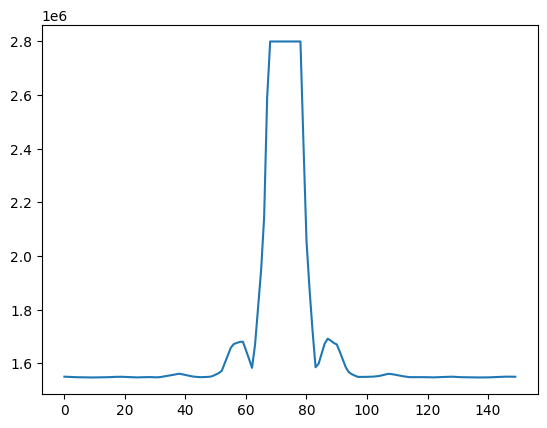

In [23]:
plt.plot(outimg[950:1100, 1024])
plt.show()

In [24]:
npix = (outimg >= full_well).sum()
print("Number of saturated pixels:", npix)

Number of saturated pixels: 49


The default values for the detector full well in the various modes reflects our current best knowledge of the properties of the actual METIS detectors. These values can be changed as in the following example, but be aware that this makes the simulations unrealistic.

**NB: There's something wrong with this example, please ignore for the time being.**

In [25]:
full_well = 1000 * metis.cmds["!DET.full_well"] * u.electron
outhdul = metis.readout(exptime=1, full_well=full_well)[0]
gain = outhdul[1].header["ESO DET2 CHIP GAIN"] * u.electron / u.adu
outimg = outhdul[1].data * u.adu * gain
fill_frac = outimg.max() / full_well << u.percent

print("\nResult\n======")
print(f"Maximum value in readout: {outimg.max():7.1f} (per DIT)")
print(f"Detector full well: {full_well:13.0f}")
print(f"Fill fraction: {fill_frac:18.1f}")

astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.005 s
astar.scopesim.effects.electronic - WARNING: DIT = 0.005 s < MINDIT = 0.011 s
astar.scopesim.effects.electronic - WARNING: The detector will likely be saturated!
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.011 s, NDIT = 90
astar.scopesim.effects.electronic - Total exposure time: 0.990 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 201
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.011 s, NDIT = 90
astar.scopesim.effects.electronic - Total exposure time: 0.990 s

Result
Maximum value in readout: 2800085.8 electron (per DIT)
Detector full well:    2800000000 electron
Fill fraction:                0.1 %
